In [1]:
#Let's import the modules we need:

%matplotlib notebook
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import regex as re

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
#let's import some of the needed image files
import glob

train_path="train"
image_files=glob.glob(train_path + "/*")

In [3]:
#Creating the dataframe for the image_data & image label
dataframe=pd.DataFrame(columns=["image_Data","image_label"])
dataframe

,image_Data,image_label


In [4]:
#importing the label csv
labels_df=pd.read_csv("train_labels.csv",index_col=["name","invasive"])
labels_df.head()

,
name,invasive
1,0
2,0
3,1
4,0
5,1


In [5]:
labels_df.loc[1].index.values

array([0], dtype=int64)

In [6]:
def get_data(data,repeat=0,batch_size=32,buffer_size=10000):
    if repeat:
        return data.repeat(repeat).shuffle(buffer_size).batch(batch_size).prefetch(1)
    else:
        return data.shuffle(buffer_size).batch(batch_size).prefetch(1)

In [7]:
from PIL import Image

def create_data_set(fileset,start=0,stop=0.50):
    start_index=int(len(fileset)*start)
    end_index=int(len(fileset)*stop)
    i=0
    reg=r"(\d+).jpg"
    for file in fileset[start_index:end_index]:
        img=Image.open(file)
        img.load()
        img_data=np.asarray(img,dtype=np.int64)
        tf_img_data=tf.Variable(img_data)
        tf_img_data=tf.image.resize(tf_img_data,[192,192])/255.
        name=re.findall(reg,file)
        tf_label=tf.Variable(labels_df.loc[int(name[0])].index.values)
        if i==0:
            train_data=tf.data.Dataset.from_tensors((tf_img_data,tf_label))
        else:
            train_data=train_data.concatenate(tf.data.Dataset.from_tensors((tf_img_data,tf_label)))
        i+=1
    return train_data,i

In [8]:
train_data_50,i_1=create_data_set(image_files,start=0,stop=0.9)
#train_data_100,i_2=create_data_set(image_files,start=0.5,stop=0.9)
validation_data,i_v=create_data_set(image_files,start=0.9,stop=1.0)

In [9]:
# #Creating the model

# model=keras.models.Sequential([keras.layers.Input(shape=(192,192,3)),
#                                keras.layers.Conv2D(64,4,activation="relu",padding="same",strides=2,kernel_regularizer='l2'),
#                                keras.layers.MaxPool2D(2),
#                                keras.layers.Conv2D(128,4,activation="relu",padding="same",strides=2,kernel_regularizer='l2'),
#                                keras.layers.MaxPool2D(2),
#                                keras.layers.Conv2D(256,8,activation="relu",padding="same",strides=2,kernel_regularizer='l2'),
#                                keras.layers.MaxPool2D(2),
#                                keras.layers.Conv2D(512,8,activation="relu",padding="same",kernel_regularizer='l2'),
#                                keras.layers.Flatten(),
#                                keras.layers.Dense(512,activation="relu"),
#                                keras.layers.Dropout(0.3),
#                                keras.layers.Dense(1,activation="sigmoid")])

# model.compile(loss="BinaryCrossentropy",optimizer="nadam",metrics=["accuracy"])

In [10]:
#Creating the model

model=keras.models.Sequential([keras.layers.Input(shape=(192,192,3)),
                               keras.layers.Conv2D(64,3,activation="relu",padding="same",strides=2,kernel_regularizer='l2'),
                               keras.layers.MaxPool2D(2),
                               keras.layers.Conv2D(128,3,activation="relu",padding="same",strides=2,kernel_regularizer='l2'),
                               keras.layers.MaxPool2D(2),
                               keras.layers.Conv2D(256,3,activation="relu",padding="same",strides=2,kernel_regularizer='l2'),
                               keras.layers.MaxPool2D(2),
                               keras.layers.Conv2D(512,3,activation="relu",padding="same",kernel_regularizer='l2'),
                               keras.layers.Flatten(),
                               keras.layers.Dense(512,activation="relu"),
                               keras.layers.Dropout(0.3),
                               keras.layers.Dense(1,activation="sigmoid")])

model.compile(loss="BinaryCrossentropy",optimizer="nadam",metrics=["accuracy"])

In [11]:
#Training the data
batch_size=16
validation_batch_size=32
n_epochs=15

history=model.fit(get_data(train_data_50,batch_size=batch_size,repeat=n_epochs+1),
                  batch_size=batch_size,
                  epochs=n_epochs,steps_per_epoch=len(train_data_50)/batch_size,
                  validation_data=get_data(validation_data,batch_size=validation_batch_size,repeat=n_epochs+1),
                  validation_batch_size=validation_batch_size,
                  validation_steps=len(validation_data)/validation_batch_size)

Epoch 1/15
129/129 [==============================] - 22s 23ms/step - loss: 2.6021 - accuracy: 0.6184 - val_loss: 0.5468 - val_accuracy: 0.7461
Epoch 2/15
129/129 [==============================] - 2s 17ms/step - loss: 0.5651 - accuracy: 0.7588 - val_loss: 0.4272 - val_accuracy: 0.8594
Epoch 3/15
129/129 [==============================] - 2s 16ms/step - loss: 0.5231 - accuracy: 0.7891 - val_loss: 0.4003 - val_accuracy: 0.8398
Epoch 4/15
129/129 [==============================] - 2s 16ms/step - loss: 0.4924 - accuracy: 0.7856 - val_loss: 0.3840 - val_accuracy: 0.8477
Epoch 5/15
129/129 [==============================] - 2s 16ms/step - loss: 0.4236 - accuracy: 0.8424 - val_loss: 0.3826 - val_accuracy: 0.8320
Epoch 6/15
129/129 [==============================] - 2s 16ms/step - loss: 0.3875 - accuracy: 0.8615 - val_loss: 0.3166 - val_accuracy: 0.8984
Epoch 7/15
129/129 [==============================] - 2s 16ms/step - loss: 0.3549 - accuracy: 0.8737 - val_loss: 0.3099 - val_accuracy: 0.882

In [12]:
#Visualizing the activations of the layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         1

In [128]:
test_image=[]
for data in train_data_50.take(10):
    test_image.append(data[0])
test_image=np.array(test_image).reshape(10,192,192,3)

layer_outputs=[layer.output for layer in model.layers[:7:2]]
activation_model=keras.models.Model(inputs=model.input,outputs=layer_outputs)

activations=activation_model.predict(test_image)

In [129]:
def create_activations(activations,n_rows=4,n_cols=10,n_images=1):
    for image in range(n_images):
        i=1
        fig,ax=plt.subplots(n_rows,n_cols)
        for index,activation in enumerate(activations):
            for a in range(n_cols):
                ax[index,a].matshow(activation[image,:,:,a],cmap="viridis")
                ax[index,a].axis("off")
                plt.show()
                i+=1

<IPython.core.display.Javascript object>


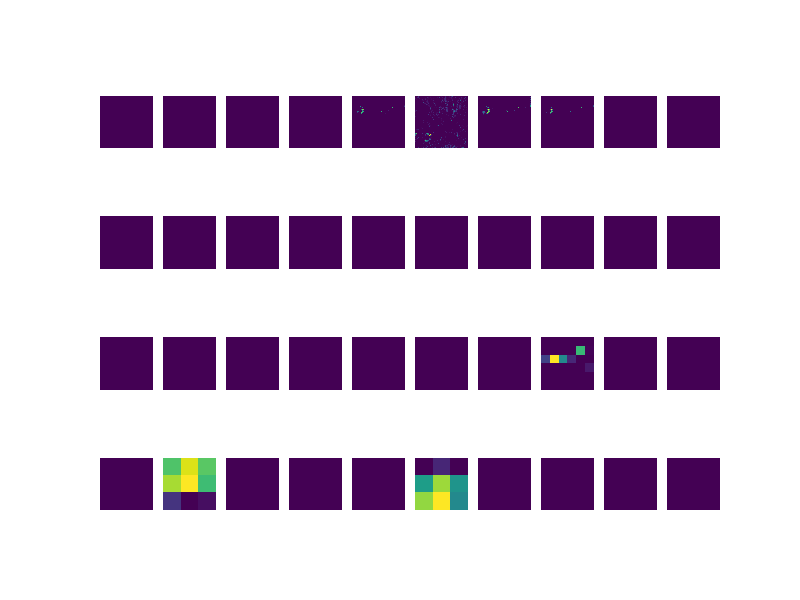

<IPython.core.display.Javascript object>


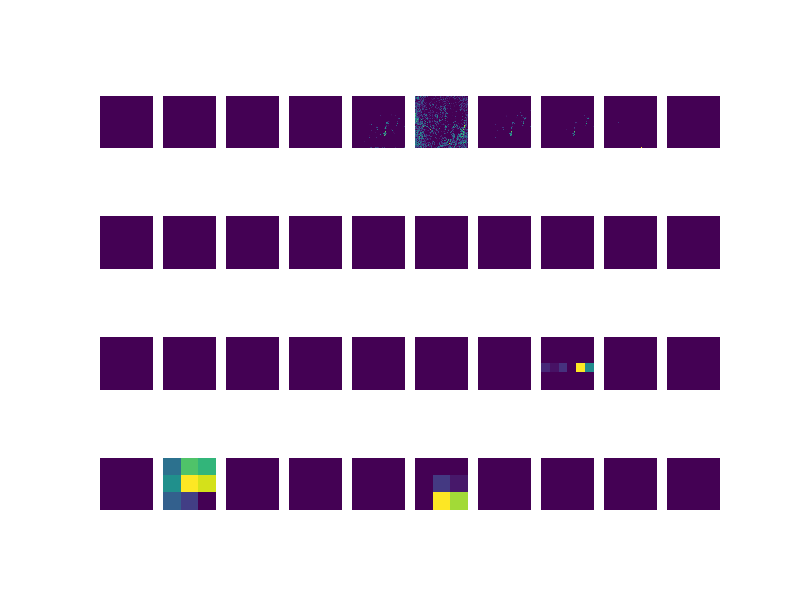

<IPython.core.display.Javascript object>


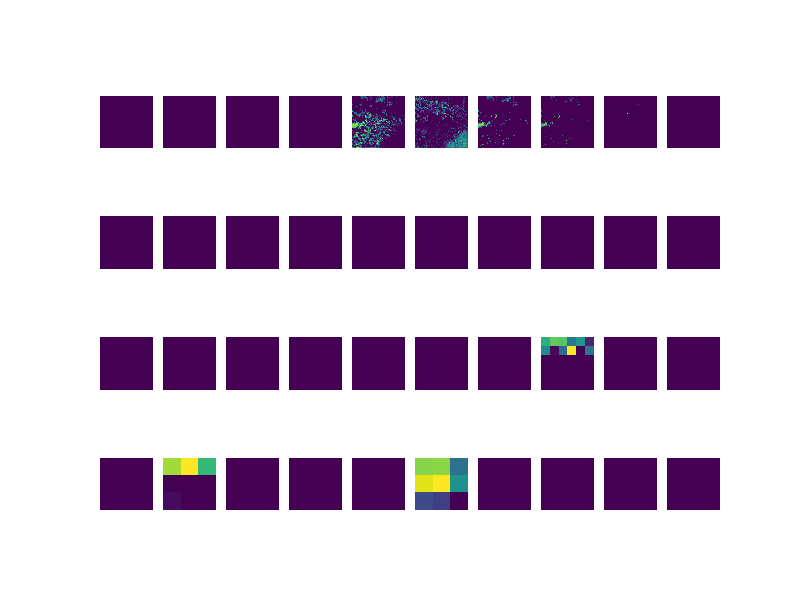

<IPython.core.display.Javascript object>


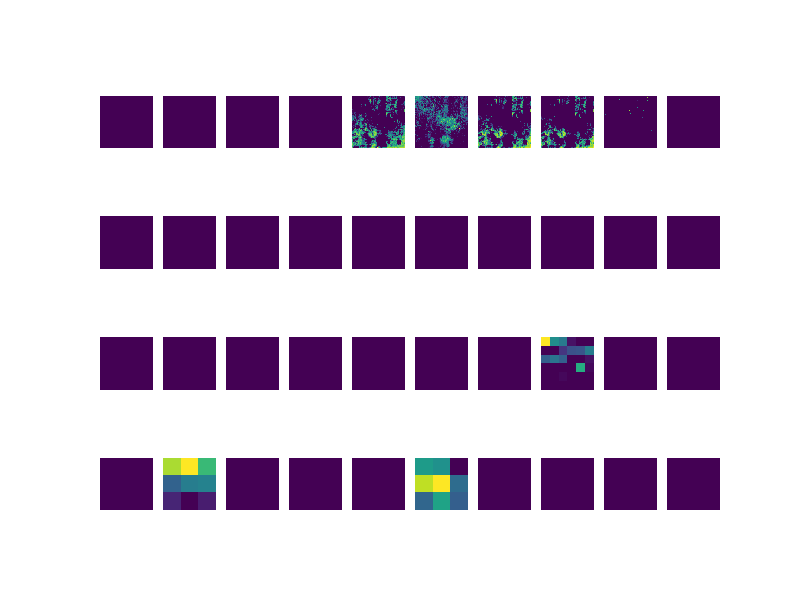

<IPython.core.display.Javascript object>


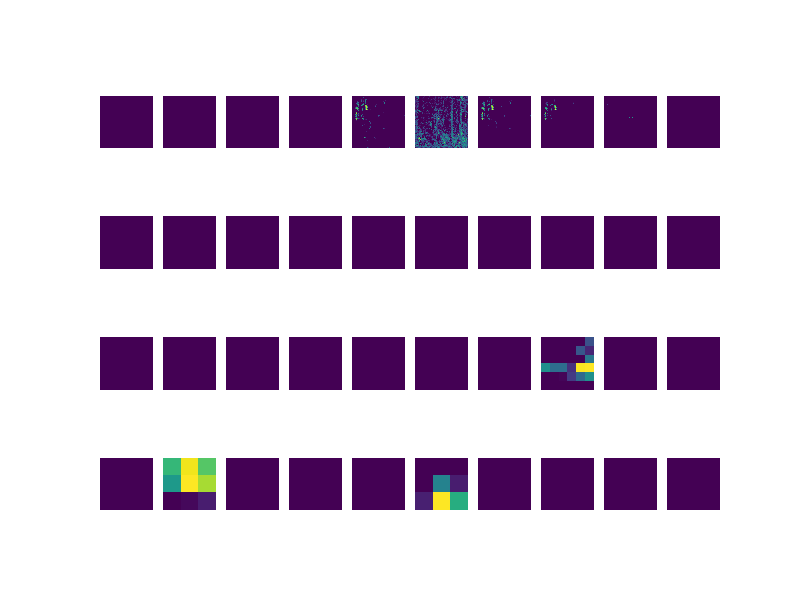

<IPython.core.display.Javascript object>


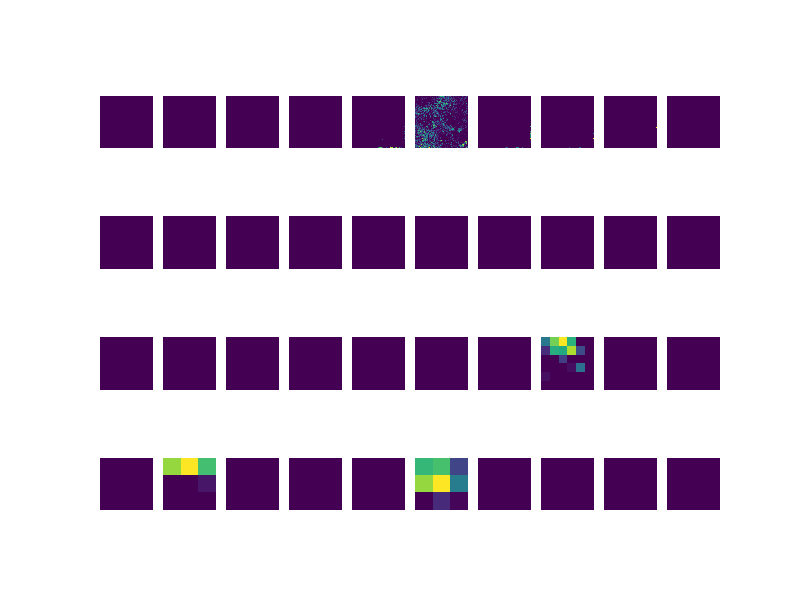

<IPython.core.display.Javascript object>


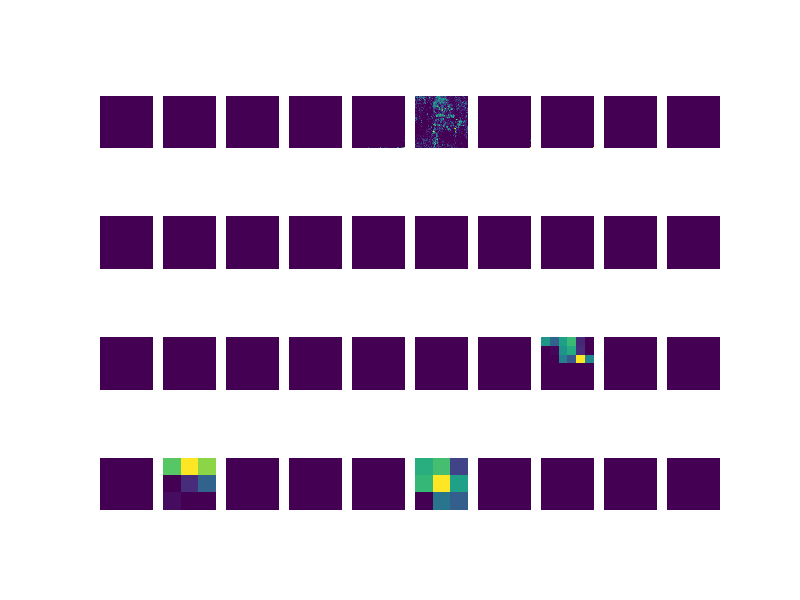

<IPython.core.display.Javascript object>


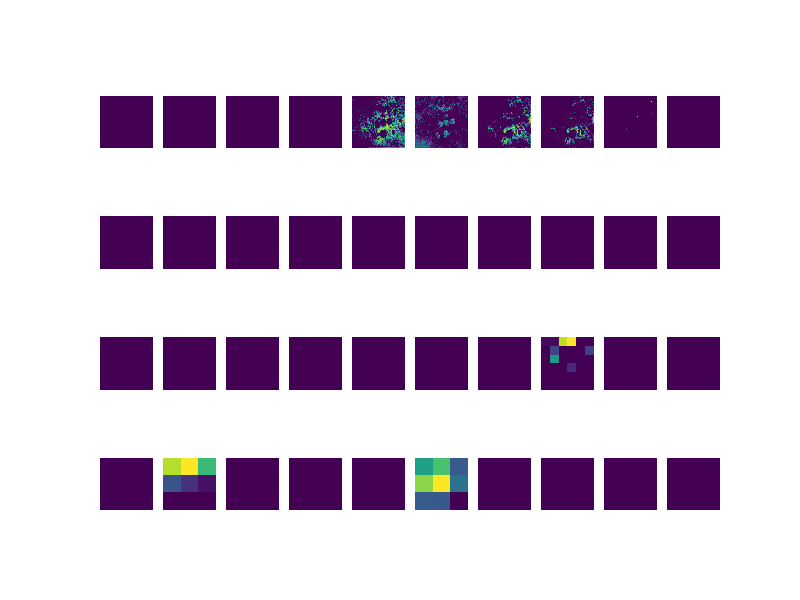

<IPython.core.display.Javascript object>


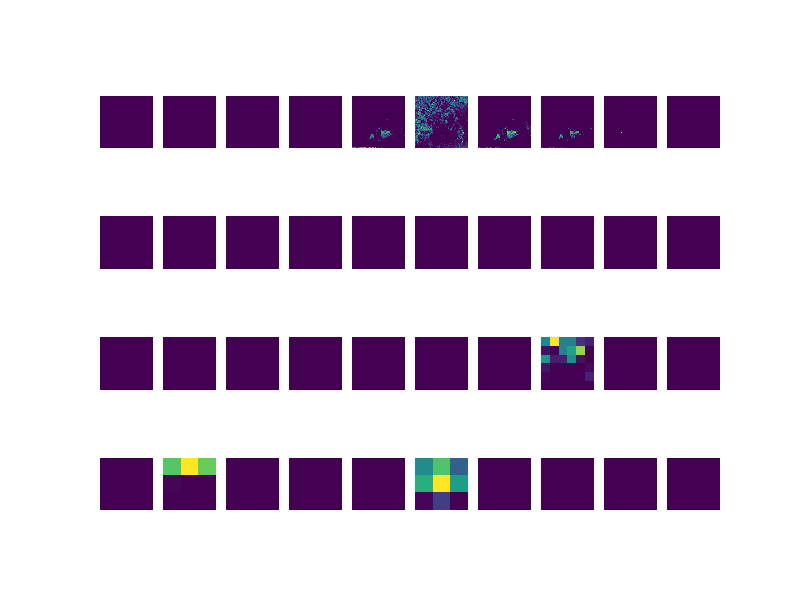

<IPython.core.display.Javascript object>


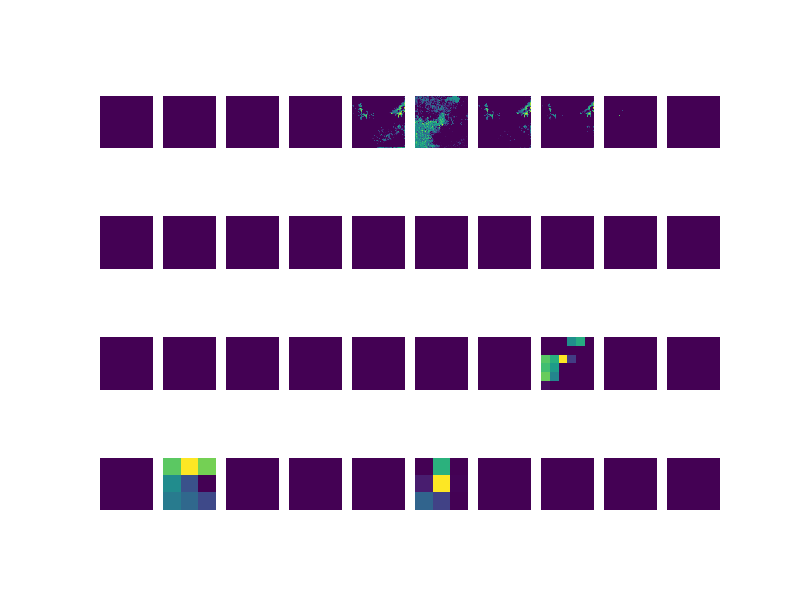

In [130]:
create_activations(activations,n_images=10)

In [132]:
#From above looks like we may have a few too many filters in the convolution layers from the test images, I reduced the filters
#but the effect on the score was deterimental. Let's keep them, what I believe is that some of the other images are causing
#activations in the other filters that we cannot pick up in our limited visualizing test set above

In [203]:
def create_test_data_names(fileset):
    names=[]
    reg=r"(\d+).jpg"
    for file in fileset:
        name=re.findall(reg,file)
        names.append(int(name[0]))
    return names

In [204]:
def create_test_data(fileset,start=0,stop=32,batch_size=32):
    i=0
    for file in fileset[start:stop]:
        img=Image.open(file)
        img.load()
        img_data=np.asarray(img,dtype=np.int64)
        tf_img_data=tf.Variable(img_data)
        tf_img_data=tf.image.resize(tf_img_data,[192,192])/255.
        if i==0:
            test_data=tf.data.Dataset.from_tensors(tf_img_data)
        else:
            test_data=test_data.concatenate(tf.data.Dataset.from_tensors(tf_img_data))
        i+=1
    return test_data.batch(batch_size)

In [205]:
#moving on to the test data
test_path="test"
test_files=glob.glob(test_path + "/*")
names=np.array(create_test_data_names(test_files)).reshape(-1,1)
names=names.astype(np.int32)

In [206]:
batch_size=32
start=0
for i in range(int(np.round(len(test_files)/batch_size))):
    stop=start+batch_size
    test_data_batched=create_test_data(test_files,start=start,stop=stop,batch_size=batch_size)
    batch_predictions=model.predict(test_data_batched)
    if i==0:
        predictions=batch_predictions
    else:
        predictions=np.concatenate((predictions,batch_predictions),axis=0)
    start=stop

In [207]:
final_predictions=np.c_[names,predictions]
final_predictions_df=pd.DataFrame(final_predictions,columns=["name","invasive"])
final_predictions_df.to_csv("Submission.csv",index=False)

![alt text](invasive_species_Score.png "Title")